# Semantische Themen-Analyse mit LSI/LSA und LDA

## Vorbereitung: Abhängigkeiten installieren

In [1]:
%load_ext autoreload
%autoreload 2

from helpers import *
import sys
import warnings
class StopExecution(Exception):
    def _render_traceback_(self):
        pass
from pprint import pprint
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Nur ausführen wenn ohne dev container gearbeitet wird
!{sys.executable} -m pip install -r ../requirements.txt
!{sys.executable} -m spacy download de_core_news_lg

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.8/567.8 MB 5.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_lg')


## Schritt 1: Aktuelle Daten herunterladen
Die Daten werden 1x pro Tag von `https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen` heruntergeladen und im Ordner `../data` abgelegt. Alle folgenden Ausführungen am selben Tag werden exakt diese Daten verwenden.

In [2]:
from datetime import datetime
import os
import requests
import json
import pandas as pd

current_date = datetime.now().strftime("%Y-%m-%d")
dataset_path = f"../data/{current_date}.json"

if os.path.exists(dataset_path):
    print("  Data already downloaded!")
else:
    url = "https://ordnungsamt.berlin.de/frontend.webservice.opendata/api/meldungen"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        with open(dataset_path, "w") as f:
            json.dump(data, f)
    else:
        print("  Error: Could not retrieve data from URL")

dataset = pd.read_json(dataset_path, orient="records", typ="series")
dataset = pd.DataFrame(
    map(
        lambda x: {
            "msg_id": x["id"],
            "betreff": x["betreff"],
            "sachverhalt": x["sachverhalt"],
        },
        dataset["index"],
    )
)

dataset.head(10)

  Data already downloaded!


,msg_id,betreff,sachverhalt
0,527563,Sperrmüll abgelagert (Spiegel),Spiegel
1,527575,Sperrmüll abgelagert (Holz-/Regalteile),Holz-/Regalteile
2,622944,Park- und Haltverbot nicht berücksichtigt,Pkw in geschützter Grünanlage aufgefahren
3,681533,Parken auf Gehweg,None
4,788708,Abfall - Müllablagerung,Bauschutt
5,883168,Gehweg/Radweg zugeparkt,None
6,885548,Park- und Haltverbot nicht berücksichtigt,Kfz steht in der kurve. Mit plane abgedeckt.
7,890996,"Parkraumbewirtschaftung - Anwohner-, Gästevign...",ca. 13.22 Uhr\n\nkeine Vignette keine Parksche...
8,950160,Straßenaufsicht - Defekte Ampel,Rotlicht an Ampel K5 komplett erloschen. Ampel...
9,1018325,Parkraumbewirtschaftung - Sonstiges,Seit vier Tagen parkt in falscher Fahrtrichtun...


## Schritt 2: Datensatz aufteilen und Texte vorverarbeiten
In diesem Schritt erstelle ich zuerst 2 verschiedene Datensätze (einen Trainings- und einen Test-Datensatz) mit einer 80/20-Verteilung. Das Test-Set wird am Ende des Notebooks zum Testen der Modelle verwendet.

Die Texte beider Datensätze werden danach wie folgt vorverarbeitet:
* Tokenisierung
* Entfernung von Stopwörtern, Punktuation und Zahlen
* Lemmatisierung
* PoS-Tagging (Part-of-Speech)

In [3]:
from sklearn.model_selection import train_test_split
import spacy


def get_cleaned_data(df: pd.DataFrame, nlp: spacy.language.Language):
    # only use sachverhalt for processing
    texts = df.sachverhalt.astype(str).to_list()
    token_ = [text.split(" ") for text in texts]

    # create bigrams
    bigram = gensim.models.Phrases(token_, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    text_bigrams = [bigram_mod[sentence] for sentence in token_]

    # construct training tuple
    df_tuple = zip(
        [" ".join(text) for text in text_bigrams],
        # set msg_id as context for later reference
        df.msg_id.apply(lambda x: {"msg_id": x}),
    )

    # run pipeline
    docs = list(nlp.pipe(df_tuple, as_tuples=True))

    # extract spacy tokens for filtering
    return extract_spacy_tokens(docs)


def run_text_pipeline(df: pd.DataFrame, nlp: spacy.language.Language):
    tidy_df = get_cleaned_data(df, nlp)

    return (
        tidy_df.loc[
            # remove short tokens
            tidy_df.lemma.apply(lambda x: len(x) > 2)
            # remove stopwords/punctuations/digits
            & ~tidy_df.is_stop
            & ~tidy_df.is_punct
            & ~tidy_df.is_digit
            # filter numerics
            & tidy_df.pos.apply(lambda x: x != "NUM")
            # & tidy_df.pos.apply(lambda x: x == "NOUN")
        ]
        .groupby(["msg_id"])
        .agg(lambda x: x.values.tolist())
        .lemma
    )


# split into training and test set
train_data, test_data = train_test_split(dataset, test_size=0.10, random_state=200)

# define spacy pipeline
nlp = spacy.load(
    "de_core_news_lg",
    disable=[
        "textcat",
        "transformer",
        "textcat_multilabel",
        "entity_ruler",
        "attribute_ruler",
    ],
)

# custom stop words
for sw in ["None", "wöchentliche_Regelmeldung", "Wöchentliche_Regelmeldung", "14-tägige_Regelmeldung"]:
    nlp.Defaults.stop_words.add(sw)
    nlp.vocab[sw].is_stop = True

#tidy_df = get_cleaned_data(test_data, nlp)
#tidy_df.loc[tidy_df.msg_id == 4950335]

# cleanup sets
training_set = run_text_pipeline(train_data, nlp)
test_set = run_text_pipeline(test_data, nlp)

training_set.shape, test_set.shape
training_set.head(20)

msg_id
527563                                             [Spiegel]
527575                                    [Holz-/Regalteile]
622944             [Pkw, geschützt, Grünanlage, aufgefahren]
788708                                           [Bauschutt]
885548                [Kfz, stehen, Kurve, planen, abdecken]
890996                          [ca., Vignette, Parkscheibe]
1018325    [parken, falsch, Fahrtrichtung, PKW, gelten, S...
1020456                 [Fahrzeug, parken, Reihe, Sicherung]
1036907    [Parken, eingeschränkt, Halteverbot, Gehweg, B...
1057377    [ca., Vignette, Parkscheibe, Fahrzeug, parken,...
1060564    [fahren, ständig, Auto, Park, hinein, Roller, ...
1142511    [ca., Woche, Elektroarbeiten, d.g, Str., übrig...
1174363                              [KFZ, parken, Kreuzung]
1211122                              [Vignette, Parkscheibe]
1687969                        [Betonstein, blau, Mülltüten]
1804983                                          [Sperrmüll]
1820063          

## Schritt 3: Textvektorisierung mit BoW und TF-IDF
In diesem Abschnitt vergleiche ich die zwei Textvektorisierungs-Methoden Bag-of-Words (BoW) und Term-Frequency Inverse-Document-Frequency (TF-IDF).

### Variante 1: Bag-of-Words

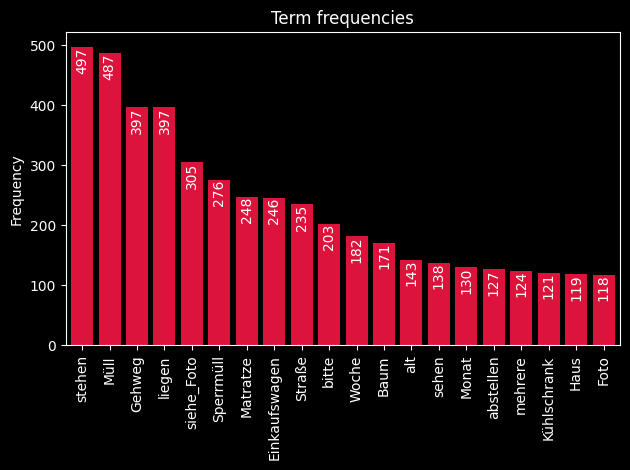

In [4]:
from helpers import get_word_freq, plot_word_freq
from gensim import corpora

# create bag-of-words corpus
bow_dict = corpora.Dictionary()
bow_corpus = [bow_dict.doc2bow(doc, allow_update=True) for doc in training_set.values]

word_freq_bow = get_word_freq(bow_corpus, bow_dict)
plot_word_freq(word_freq_bow, 20)

### Variante 2: TF-IDF (Term-Frequency Inverse-Document-Frequency)

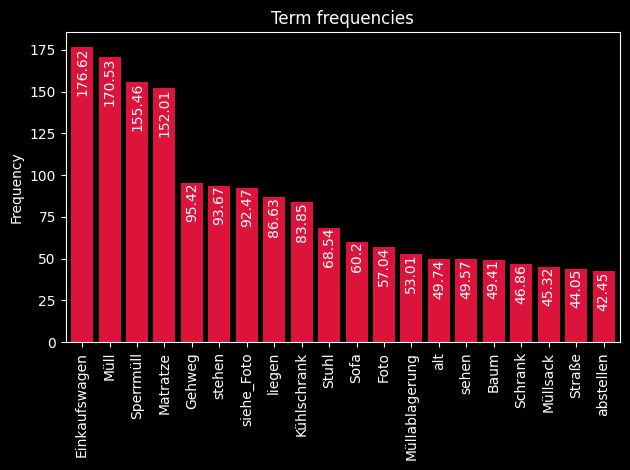

In [5]:
from gensim.models import TfidfModel

# create tf-idf model
tfidf_dict = corpora.Dictionary(training_set.values)
tfidf = TfidfModel(dictionary=tfidf_dict, smartirs='ntc')
tfidf_corpus = [tfidf[tfidf_dict.doc2bow(doc)] for doc in training_set.values]

# get overall tf-idf scores
word_freq_tfidf = get_word_freq(tfidf_corpus, tfidf_dict)
plot_word_freq(word_freq_tfidf, 20)

## Schritt 4: Modell-Training
Nun werde ich 2 verschiedene Varianten für die Themen-Extraktion vergleichen: Latent Semanting Indexing/Analysis (LSA/LSI) und Latent Dirichlet Allocation (LDA). In einem ersten Schritt werde ich für verschiedene Anzahl Themen (`num_topcs`-Parameter für das `LsiModel` resp. `LdaMulticore`) den Koheränz-Score berechnen und auf einem Diagramm visualisieren. Dies soll mir erlauben, für das spätere Modell-Training die optimale Anzahl Themen zu wählen.

### Variante 1: LSA-Modell trainieren
Zuerst werde ich versuchen, die optimale Anzahl Themenfelder anhand eines Diagramms zu eruieren.

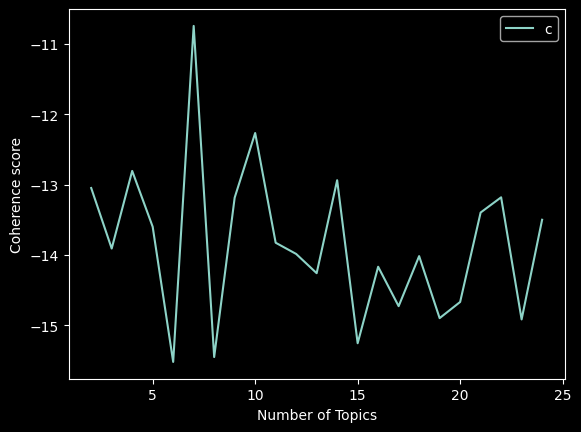

In [6]:
import gensim

# use TF-IDF corpus to train LSI model
lsa_dict = gensim.corpora.Dictionary(training_set.values)
lsa_tfidf = TfidfModel(dictionary=lsa_dict, smartirs='ntc')
lsa_corpus = [lsa_tfidf[lsa_dict.doc2bow(doc)] for doc in training_set.values]

start, stop, step = 2, 25, 1

_, coherence_values = compute_coherence_values(
    dict=lsa_dict,
    corpus=lsa_corpus,
    training_set=training_set.values,
    model_type="lsi",
    coherence="u_mass",
    start=start, stop=stop, step=step
)
plot_coherence_graph(coherence_values, start, stop, step)

Das Diagram zeigt auf, dass die optimale Anzahl Themen bei ca. 6 liegt, mit höheren Werten pendelt sich der Coherence-Score auf einem höheren Niveau ein (wobei bei der u_mass Metrik der tiefste Wert der beste ist).

In [7]:
num_topics = 6

lsi_model = LsiModel(lsa_corpus, num_topics=num_topics, id2word=lsa_dict)
topics = get_specific_topics(lsi_model)

for topic_id, terms in topics.items():
    print(f"Topic {topic_id}:")
    for term, weight in terms:
        print(f"  {term}: {weight:.4f}")

# Compute Perplexity & Coherence Score
coherence_model_lsa = CoherenceModel(
    model=lsi_model, corpus=lsa_corpus, dictionary=lsa_dict, coherence="u_mass"
)
coherence_lsa = coherence_model_lsa.get_coherence()
print("Coherence Score: ", coherence_lsa)

Topic 0:
  Einkaufswagen: 0.9868
  Müll: 0.1126
  Matratze: 0.0769
  Sperrmüll: 0.0644
  Gehweg: 0.0205
Topic 1:
  Sperrmüll: -0.7088
  Matratze: -0.6573
  Müll: -0.1574
  Einkaufswagen: 0.1229
  Gehweg: -0.0841
Topic 2:
  Matratze: 0.7234
  Sperrmüll: -0.6861
  Müll: 0.0382
  siehe_Foto: 0.0287
  Gehweg: -0.0189
Topic 3:
  Müll: 0.9650
  Matratze: -0.1594
  Sperrmüll: -0.1089
  Einkaufswagen: -0.0968
  liegen: 0.0756
Topic 4:
  Kühlschrank: -0.9805
  siehe_Foto: -0.0848
  Gehweg: -0.0804
  stehen: -0.0697
  Stuhl: -0.0640
Topic 5:
  siehe_Foto: -0.4668
  Foto: -0.4198
  sehen: -0.2976
  liegen: -0.2922
  Gehweg: -0.2901
Coherence Score:  -14.089232669264158


## Variante 2: LDA-Modell trainieren
Als zweite Variante trainiere ich mit den Daten ein LDA-Modell (Latent Dirichlet Allocation) zur Ermittlung der Top-Themen in den Daten. Auch hier soll in einem ersten Schritt die ideale Anzahl Themen anhand des Coherence-Scores ermittelt werden (dieses Mal auf Basis des `LdaMulticore`-Modells).

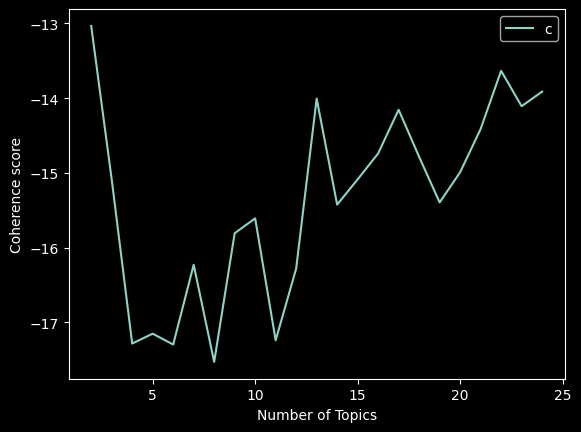

In [8]:
import gensim

lda_dict = gensim.corpora.Dictionary(training_set.values)
lda_tfidf = TfidfModel(dictionary=lsa_dict, smartirs='ntc')
lda_corpus = [lda_tfidf[lda_dict.doc2bow(doc)] for doc in training_set.values]

start, stop, step = 2, 25, 1
_, coherence_values = compute_coherence_values(
    dict=lda_dict,
    corpus=lda_corpus,
    model_type="lda",
    training_set=training_set,
    coherence="u_mass",
    alpha="symmetric", eta=None,
    start=start, stop=stop, step=step
)
plot_coherence_graph(coherence_values, start, stop, step)

Bei LDA zeigt sich zum einen eine tiefere Varianz in der Koheränz und zum anderen eine Verschiebung hin zu mehr Themenfelder. Wir trainieren das LDA-Modell mit ca. 8 Themenfeldern und visualisieren die Resultate mit dem Python-Paket `pyLDAvis`, zur Evaluation wird wieder der Coherence-Score herangezogen.

In [9]:
from gensim.models import CoherenceModel, LdaMulticore
import pyLDAvis.gensim_models

num_topics = 8

# train model
lda_model = LdaMulticore(
    lda_corpus,
    num_topics=num_topics,
    id2word=lda_dict,
    passes=1,
    chunksize=1000,
    iterations=100,
    workers=5,
    random_state=200,
    alpha="symmetric",
)

# Compute Perplexity & Coherence Score
coherence_model_lda = CoherenceModel(
    model=lda_model, corpus=lda_corpus, texts=training_set.values, dictionary=lda_dict, coherence="u_mass"
)
coherence_lda = coherence_model_lda.get_coherence()
print("Perplexity: ", lda_model.log_perplexity(lda_corpus))
print("Coherence Score: ", coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, lda_corpus, lda_dict, sort_topics=False, mds='tsne')
pyLDAvis.display(vis)

Perplexity:  -10.323944168103827
Coherence Score:  -12.537039493587507


# Schritt 5: LDA-Modell evaluieren
Anhand des Test-Sets und der zugewiesenen Kategorien im Feld `betreff` werden wir nun prüfen, wie genau die Einordnungen des Modells sind.

In [10]:
lda_test_dict = gensim.corpora.Dictionary(test_set.values)
lda_test_tfidf = TfidfModel(dictionary=lda_test_dict, smartirs='ntc')
lda_test_corpus = [lda_test_tfidf[lda_test_dict.doc2bow(doc)] for doc in test_set.values]

predictions = lda_model.get_document_topics(lda_test_corpus)

dfs = []
for i, preds in enumerate(predictions):
    doc = test_set.iloc[i]
    msg_id = test_set.keys()[i]

    # get original subject/text from source data
    subject = test_data[test_data.msg_id == msg_id].betreff.values[0]
    text = test_data[test_data.msg_id == msg_id].sachverhalt.values[0]

    # sort topics by score, get top topic and its top 5 terms
    preds.sort(key=lambda x: x[1], reverse=True)
    topic_id, probability = preds[0]
    top_terms = [topic[0] for topic in lda_model.show_topic(topic_id, 5)[:]]

    doc_df = pd.DataFrame(
        [(msg_id, subject, text, topic_id, top_terms, probability)],
        columns=["msg_id", "subject", "text", "topic_id", "top_terms", "probability"],
    )
    dfs.append(doc_df)

df = pd.concat(dfs)
df.head(20)

,msg_id,subject,text,topic_id,top_terms,probability
0,950160,Straßenaufsicht - Defekte Ampel,Rotlicht an Ampel K5 komplett erloschen. Ampel...,1,"[Matratze, Einkaufswagen, Müllablagerung, steh...",0.410201
0,1852450,Bauabfälle abgelagert,Dachpappe,4,"[Müll, Einkaufswagen, liegen, Holzpalette, Pal...",0.561720
0,1952812,Müllablagerung,"Speisereste, Glas",2,"[Einkaufswagen, Müll, Matratze, Couch, sehen]",0.637017
0,2064478,Abfall - Müllablagerung,Überquellender und verdreckter Altkleiderconta...,4,"[Müll, Einkaufswagen, liegen, Holzpalette, Pal...",0.679292
0,2173627,Elektroschrott abgelagert,4x Altreifen,4,"[Müll, Einkaufswagen, liegen, Holzpalette, Pal...",0.562270
0,2305087,Müllablagerung,"Essensreste, Mülltüten",0,"[Sperrmüll, Einkaufswagen, Stuhl, siehe_Foto, ...",0.636161
0,2851983,Lärm - Gaststätte,\n6:20 uhr ( Nachtruhestörung)hochstellen von ...,0,"[Sperrmüll, Einkaufswagen, Stuhl, siehe_Foto, ...",0.461203
0,3704085,Abfall - Schrottfahrräder,Räder\n,6,"[Kühlschrank, Sessel, Foto, Schrank, Blockiert...",0.562076
0,3755787,Campieren,"Drogensüchtige Person, nächtigt seit Tagen an ...",0,"[Sperrmüll, Einkaufswagen, Stuhl, siehe_Foto, ...",0.379215
0,3778704,Abfall - Schrottfahrräder,Fahrrad mit 1 Rad,0,"[Sperrmüll, Einkaufswagen, Stuhl, siehe_Foto, ...",0.636107
